In [17]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import LatentDirichletAllocation as LDA
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import re
from datetime import datetime
import streamlit as st  # For dashboard creation
from sklearn.utils import resample  # Import resample from sklearn.utils

In [2]:
# Download NLTK data files
nltk.download('punkt')
nltk.download('stopwords')

# Load the Dataset
df = pd.read_csv("Recipe_Reviews.csv")
df.head()

[nltk_data] Downloading package punkt to C:\Users\Saurav
[nltk_data]     Sahu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Saurav
[nltk_data]     Sahu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


In [3]:
# Inspect the Dataset
print(df.info())
print(df.head())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18182 entries, 0 to 18181
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       18182 non-null  int64 
 1   recipe_number    18182 non-null  int64 
 2   recipe_code      18182 non-null  int64 
 3   recipe_name      18182 non-null  object
 4   comment_id       18182 non-null  object
 5   user_id          18182 non-null  object
 6   user_name        18182 non-null  object
 7   user_reputation  18182 non-null  int64 
 8   created_at       18182 non-null  int64 
 9   reply_count      18182 non-null  int64 
 10  thumbs_up        18182 non-null  int64 
 11  thumbs_down      18182 non-null  int64 
 12  stars            18182 non-null  int64 
 13  best_score       18182 non-null  int64 
 14  text             18180 non-null  object
dtypes: int64(10), object(5)
memory usage: 2.1+ MB
None
   Unnamed: 0  recipe_number  recipe_code         recipe_name  \
0    

In [5]:
# Preprocess the Data
# Handle Missing Values
df = df.dropna(subset=['text', 'stars'])
df['thumbs_up'] = df['thumbs_up'].fillna(0)
df['thumbs_down'] = df['thumbs_down'].fillna(0)

# Convert Unix Timestamp to Datetime
df['created_at'] = pd.to_datetime(df['created_at'], unit='s')

# Clean Text Data
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

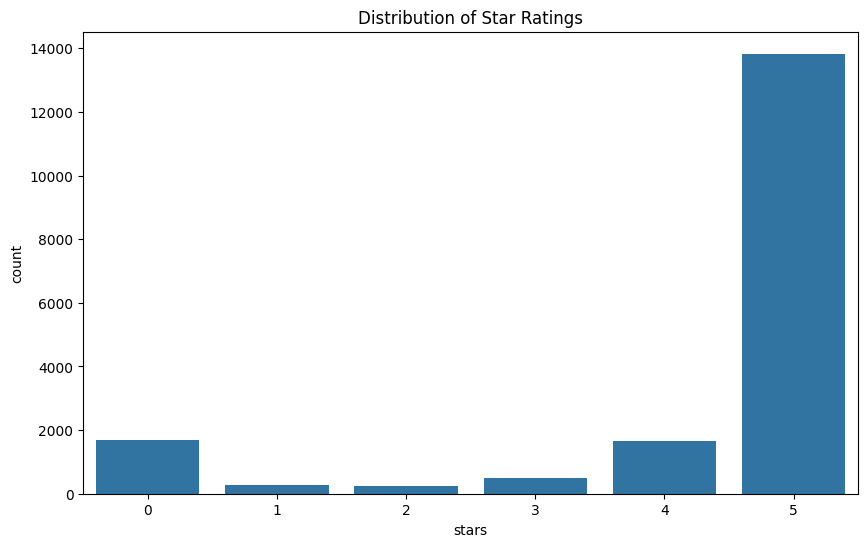

In [6]:
# Step 3: Exploratory Data Analysis (EDA)
# Plot the distribution of star ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='stars', data=df)
plt.title('Distribution of Star Ratings')
plt.show()

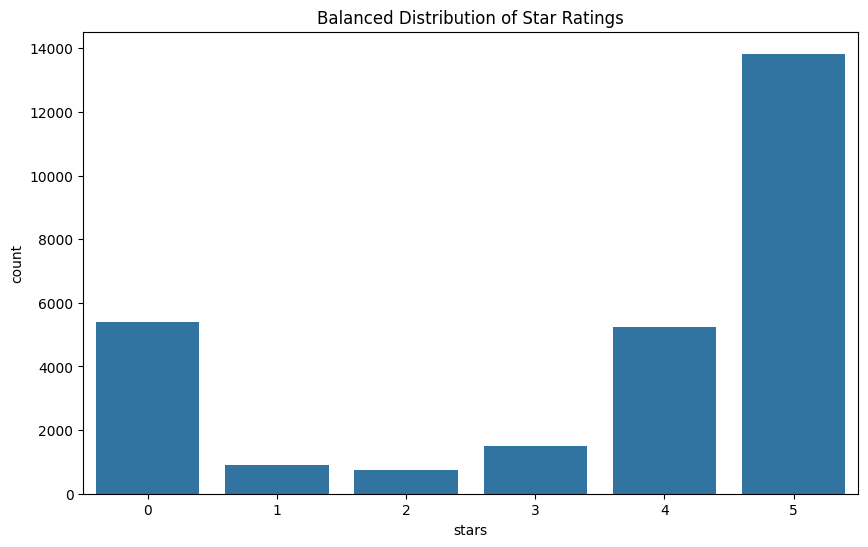

In [7]:
# Step 4: Handle Imbalanced Data
# Separate majority and minority classes
majority_class = df[df.stars == 5]
minority_classes = df[df.stars != 5]

# Upsample minority class
upsampled_minority = resample(minority_classes, replace=True, n_samples=len(majority_class), random_state=42)

# Combine majority class with upsampled minority class
df_balanced = pd.concat([majority_class, upsampled_minority])

# Check the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='stars', data=df_balanced)
plt.title('Balanced Distribution of Star Ratings')
plt.show()

In [8]:
# Step 5: Feature Engineering
# Extract features from text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(df_balanced['cleaned_text'])
tfidf_features

<27654x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 473051 stored elements in Compressed Sparse Row format>

In [10]:
df_balanced.head()

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,cleaned_text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,2022-10-13 00:11:29,0,0,0,5,527,"I tweaked it a little, removed onions because ...",tweaked little removed onions onion haters hou...
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,7,0,5,724,Bush used to have a white chili bean and it ma...,bush used white chili bean made recipe super s...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,2022-09-28 22:35:57,0,3,0,5,710,I have a very complicated white chicken chili ...,complicated white chicken chili recipe made ye...
5,5,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2Do918IutExN0pWEOFMU4cbiT8v,u_BALTQJIvWtYr,nikhita,1,2022-08-24 15:19:11,0,3,1,5,518,amazing! my boyfriend loved it so much! going ...,amazing boyfriend loved much going make week
6,6,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_24hhcbywpsgGqG7yeDFH1IPZCb8,u_HuJVXMzQqJoI,Sandy1256,1,2022-02-05 19:20:05,0,11,0,5,833,Wow!!! This recipe is excellent as written!! ...,wow recipe excellent written change made used ...


In [11]:
# Step 6: Sentiment Analysis
# Split the data
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df_balanced['stars'], test_size=0.2, random_state=42)

# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.54      0.59      1096
           1       0.85      0.63      0.72       161
           2       0.85      0.41      0.55       153
           3       0.80      0.52      0.63       320
           4       0.67      0.61      0.64      1046
           5       0.73      0.87      0.80      2755

    accuracy                           0.72      5531
   macro avg       0.76      0.60      0.66      5531
weighted avg       0.72      0.72      0.71      5531

Logistic Regression Confusion Matrix:
[[ 587    7    1    7   51  443]
 [  13  101    6    7   12   22]
 [  14    1   62   12   33   31]
 [  25    3    3  167   50   72]
 [  71    3    0   12  639  321]
 [ 168    4    1    3  171 2408]]


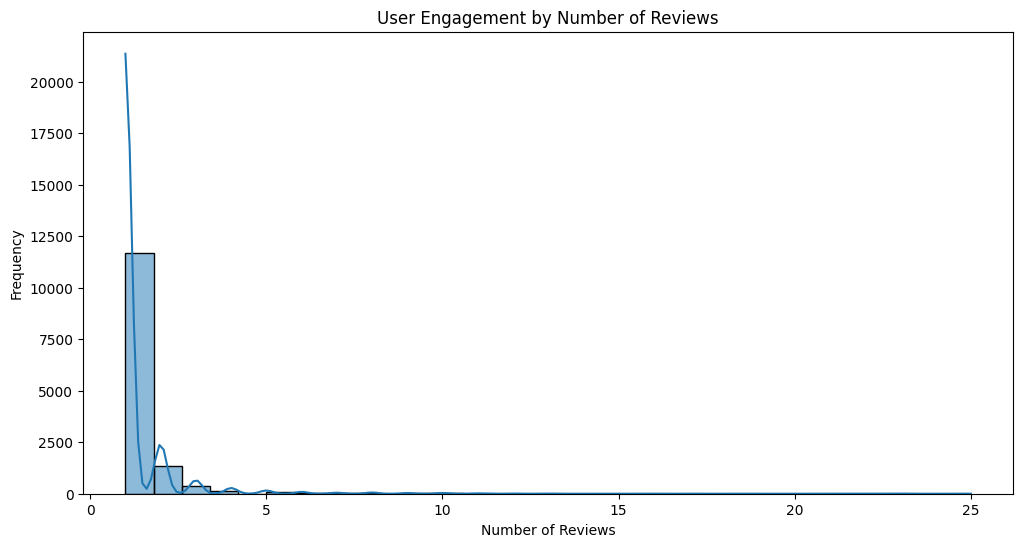

In [12]:
# Step 7: User Behavior Analysis
# Group by user and aggregate review counts
user_engagement = df.groupby('user_id').agg({'comment_id': 'count', 'thumbs_up': 'sum', 'thumbs_down': 'sum'}).reset_index()

# Plot user engagement
plt.figure(figsize=(12, 6))
sns.histplot(user_engagement['comment_id'], bins=30, kde=True)
plt.title('User Engagement by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Step 8: Model Building
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_y_pred = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1096
           1       0.97      0.91      0.94       161
           2       0.99      0.88      0.93       153
           3       0.99      0.91      0.95       320
           4       0.99      0.92      0.95      1046
           5       0.92      0.99      0.95      2755

    accuracy                           0.95      5531
   macro avg       0.97      0.92      0.95      5531
weighted avg       0.95      0.95      0.95      5531

Random Forest Confusion Matrix:
[[1000    0    0    0    3   93]
 [   1  147    0    0    0   13]
 [   0    2  135    2    0   14]
 [   0    1    0  292    2   25]
 [   2    0    1    0  959   84]
 [  23    1    0    2    9 2720]]


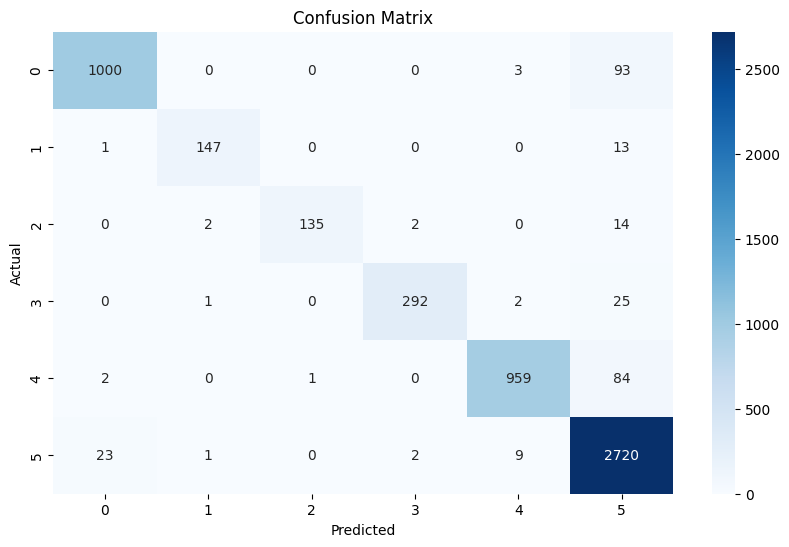

In [14]:
# Step 9: Evaluate the Model
# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
# Step 10: Address Overfitting
# Cross-validation
scores = cross_val_score(rf_model, tfidf_features, df_balanced['stars'], cv=5)
print(f'Cross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean()}')

Cross-validation scores: [0.95552341 0.94666426 0.958597   0.95154583 0.95189873]
Mean cross-validation score: 0.9528458469981622


In [18]:
# Step 11: Build a Recommendation System
# Initialize LDA
lda_model = LDA(n_components=5, random_state=42)

# Fit the model
lda_model.fit(tfidf_features)

# Get the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f'Topic {topic_idx}:')
        print(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), 10)

Topic 0:
recipe family made make love best favorite loved everyone ever
Topic 1:
recipe cake sugar bread used made make cup like banana
Topic 2:
used added recipe chicken cheese soup good add instead sauce
Topic 3:
easy good make delicious recipe loved great tasty made yummy
Topic 4:
pie recipe make like good would sugar try apple stars


In [31]:
# Step 12: Create a Dashboard
# Streamlit Dashboard
st.title('Recipe Review and Sentiment Analysis Dashboard')

# Function to plot distribution of star ratings
def plot_star_distribution():
    plt.figure(figsize=(10, 6))
    sns.countplot(x='stars', data=df_balanced)
    plt.title('Distribution of Star Ratings')
    st.pyplot(plt)

# Function to plot user engagement
def plot_user_engagement():
    plt.figure(figsize=(12, 6))
    sns.histplot(user_engagement['comment_id'], bins=30, kde=True)
    plt.title('User Engagement by Number of Reviews')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Frequency')
    st.pyplot(plt)

# Display distribution of star ratings
st.subheader('Distribution of Star Ratings')
plot_star_distribution()

# Display user engagement
st.subheader('User Engagement by Number of Reviews')
plot_user_engagement()

In [23]:
# Step 13: Answer Specific Questions
# Top 5 Most Popular Recipes
top_recipes = df.groupby('recipe_name')['stars'].mean().sort_values(ascending=False).head(5)
print("Top 5 Most Popular Recipes:")
print(top_recipes)

Top 5 Most Popular Recipes:
recipe_name
Rustic Italian Tortellini Soup    4.731343
Corn Pudding                      4.711409
Pumpkin Bread                     4.645349
Macaroni Coleslaw                 4.633508
Zucchini Pizza Casserole          4.632530
Name: stars, dtype: float64


In [24]:
# Top 5 Least Popular Recipes
least_popular_recipes = df.groupby('recipe_name')['stars'].mean().sort_values(ascending=True).head(5)
print("Top 5 Least Popular Recipes:")
print(least_popular_recipes)

Top 5 Least Popular Recipes:
recipe_name
Pineapple Orange Cake           2.614973
Fluffy Key Lime Pie             2.942478
Caramel Heavenlies              3.302326
Twice-Baked Potato Casserole    3.776786
Li’l Cheddar Meat Loaves        3.779528
Name: stars, dtype: float64


In [25]:
# 10 Recipes to Discontinue
discontinued_recipes = df.groupby('recipe_name')['stars'].mean().sort_values().head(10)
print("10 Recipes to Discontinue:")
print(discontinued_recipes)

10 Recipes to Discontinue:
recipe_name
Pineapple Orange Cake           2.614973
Fluffy Key Lime Pie             2.942478
Caramel Heavenlies              3.302326
Twice-Baked Potato Casserole    3.776786
Li’l Cheddar Meat Loaves        3.779528
Peanut Butter Cup Cheesecake    3.802083
Caramel-Pecan Cheesecake Pie    3.822857
Flavorful Pot Roast             3.865854
Basic Homemade Bread            3.894207
Winning Apple Crisp             3.927835
Name: stars, dtype: float64


In [29]:
# User Satisfaction Plot
df['year'] = df['created_at'].dt.year
satisfaction_over_time = df.groupby('year')['stars'].mean()
print("User Satisfaction Over Time:")
print(satisfaction_over_time)

User Satisfaction Over Time:
year
2021    4.300544
2022    3.888889
Name: stars, dtype: float64


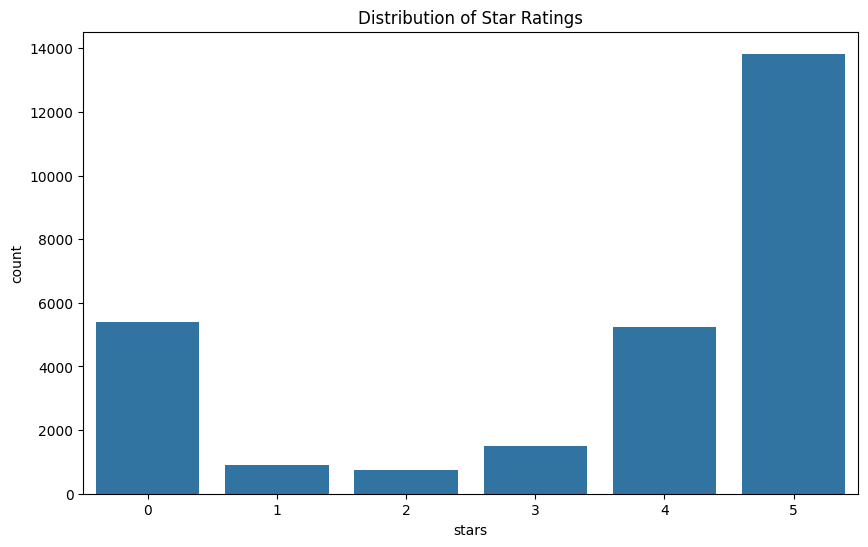

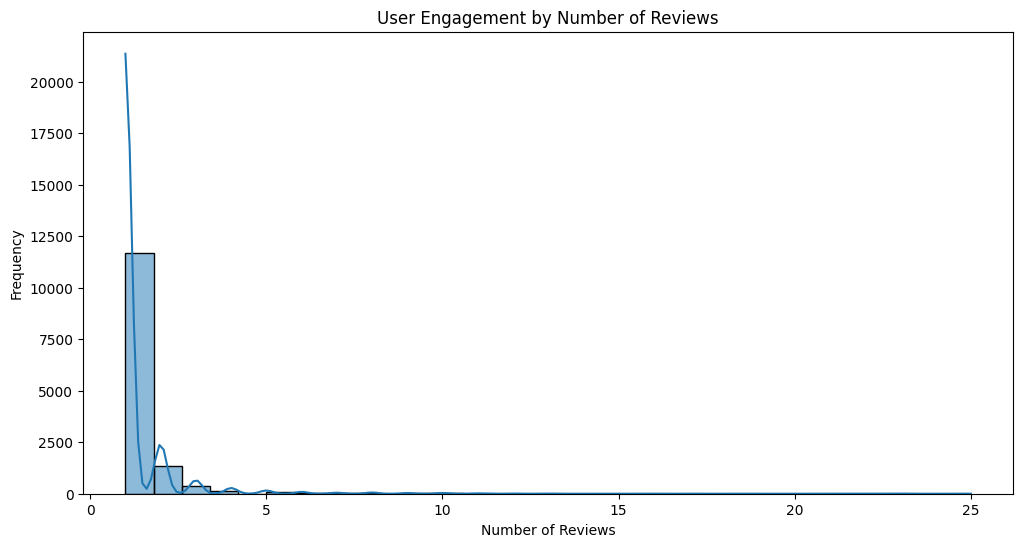

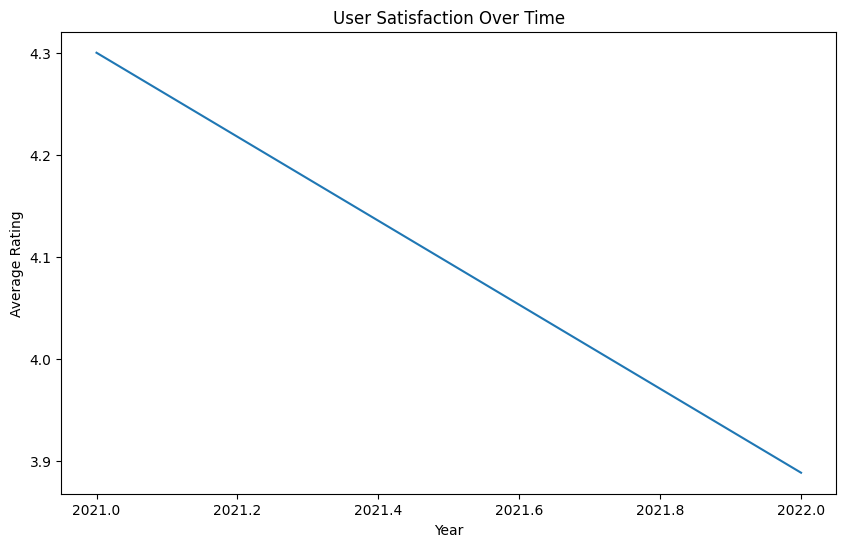

In [32]:
# Plot User Satisfaction Over Time
plt.figure(figsize=(10, 6))
satisfaction_over_time.plot(kind='line')
plt.title('User Satisfaction Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

# Step 14: Document and Present Results
# This step involves creating a summary report and presenting the results.
# You can use Markdown or PDF to document the findings.